# Object detection Examples

&nbsp;

<img align="center" src="https://media-exp1.licdn.com/dms/image/C4E1BAQFay3CGU2VmRg/company-background_10000/0/1621019049425?e=2159024400&v=beta&t=dmPCWeJlWvkzmM019V4_oKMluIPkQPX52i0zdgP-x2M" alt="nn" style="width: 1200px;"/>

&nbsp;&nbsp;Please visit us at https://amperecomputing.com

&nbsp;

## COCO Dataset Overview
<img align="left" src="https://cocodataset.org/images/coco-logo.png" alt="nn" style="width: 200px;"/>

&nbsp;

These examples are using subset of COCO object detection validation set from year 2014.
COCO is a large-scale object detection dataset that has been instrumental in advancing computer vision and deep learning research.

More info can be found here: https://cocodataset.org/

&nbsp;

In [1]:
import os
import time
import torch
import torchvision
import subprocess
import numpy as np
from matplotlib import pyplot as plt

from utils.cv.coco import COCODataset
import utils.benchmark as bench_utils
import utils.misc as utils
import utils.post_processing as pp
import sys
import cv2

LAT_BATCH_SIZE = 1

## Latency with ResNet-50 v1.5 in fp32 precision

AIO offers a significant speed-up in standard fp32 inference scenarios. AIO exposes API to control behavior of the optimizer. This example shows the performance of ResNet-50 v1 model in fp32 precision.
Original ResNet paper can be found here: https://arxiv.org/pdf/1512.03385.pdf

In [2]:
# ! AIO_NUM_THREADS should be set prior to launching jupyter notebook !
num_threads = os.getenv('AIO_NUM_THREADS')
images_path = os.getenv('COCO_IMG_PATH')
anno_path = os.getenv('COCO_ANNO_PATH')

if num_threads is None:
    print("AIO_NUM_THREADS not defined")
    exit()
else:
    print("AIO_NUM_THREADS = {}".format(num_threads))

# Set Pytorch intra thread count, which should match AIO_NUM_THREADS
torch.set_num_threads(int(num_threads))

# Load model and apply Torchscript for inference deployment
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()
model_script = torch.jit.script(model)
frozen_script = torch.jit.freeze(model_script)

# ImageNet dataset initialization
input_shape = (300, 300)
dataset_aio = COCODataset(LAT_BATCH_SIZE, "BGR", "COCO_val2014_000000000000", images_path, anno_path,
                          pre_processing="PyTorch_objdet", sort_ascending=True, order="NCHW")
dataset_non_aio = COCODataset(LAT_BATCH_SIZE, "BGR", "COCO_val2014_000000000000", images_path, anno_path,
                          pre_processing="PyTorch_objdet", sort_ascending=True, order="NCHW")


input_array = dataset_aio.get_input_array(input_shape)
num_of_runs = dataset_aio.available_instances
if num_of_runs <= 2:
    print("The first two runs are warm up. Please provide more than two input images")
    exit()

torch._C._aio_force_enable()
count = 0
total_time = 0
for _ in range(num_of_runs):
    with torch.no_grad():
        start = time.time()
        output_tensor = frozen_script(input_array)
        end = time.time()
        output_aio = output_tensor[1]
        for i in range(LAT_BATCH_SIZE):
            for d in range(output_aio[i]['boxes'].shape[0]):
                dataset_aio.submit_bbox_prediction(
                    i,
                    dataset_aio.convert_bbox_to_coco_order(output_aio[i]['boxes'][d].tolist()),
                    output_aio[i]['scores'][d].item(),
                    output_aio[i]['labels'][d].item()
                )
        count = count + 1
        if count > 2:
            total_time += end - start
latency_aio = total_time / (count - 2) 

torch._C._aio_force_disable()
input_array = dataset_non_aio.get_input_array(input_shape)
num_of_runs = dataset_non_aio.available_instances
count = 0
total_time = 0
for _ in range(num_of_runs):
    with torch.no_grad():
        start = time.time()
        output_tensor = frozen_script(input_array)
        end = time.time()
        output_non_aio = output_tensor[1]
        for i in range(LAT_BATCH_SIZE):
            for d in range(output_non_aio[i]['boxes'].shape[0]):
                dataset_non_aio.submit_bbox_prediction(
                    i,
                    dataset_non_aio.convert_bbox_to_coco_order(output_non_aio[i]['boxes'][d].tolist()),
                    output_non_aio[i]['scores'][d].item(),
                    output_non_aio[i]['labels'][d].item()
                )
        count = count + 1
        if count > 2:
            total_time += end - start
latency_non_aio = total_time / (count - 2)
        

AIO_NUM_THREADS = 1
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/karol/anaconda3/lib/python3.8/site-packages/torchvision-0.10.0a0+ca1a620-py3.8-linux-x86_64.egg/torchvision/models/detection/ssd.py:359: UserWarning: SSD always returns a (Losses, Detections) tuple in scripting
  warnings.warn("SSD always returns a (Losses, Detections) tuple in scripting")


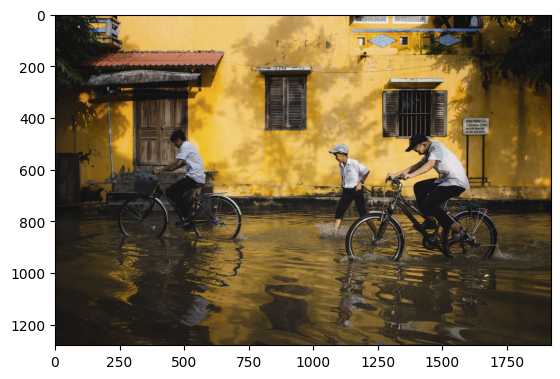

ssd300_vgg16 FP32 predictions with AIO enabled:
Latency = 710 ms
Loading and preparing results...
Converting ndarray to lists...
(1000, 7)
0/1000
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.320
 Average Recall     (AR) @[ IoU=0

{'coco_map': 0.21914191419141912}

In [3]:
# visualizing output
# for the purpose of visualizing results let's load the image without pre-processing
img = cv2.imread(str(dataset_aio.path_to_latest_image))

# show the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print("ssd300_vgg16 FP32 predictions with AIO enabled:")
print("Latency = {:.0f} ms".format(latency_aio * 1000))
dataset_aio.summarize_accuracy()

print("ssd300_vgg16 FP32 predictions with AIO disabled:")
print("Latency = {:.0f} ms".format(latency_non_aio * 1000))
dataset_non_aio.summarize_accuracy()